In [2]:
import re
import os
import pandas as pd

from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance

In [26]:
covers = os.listdir('../covers/')

dims = []
for cover in covers:
    im = Image.open('../covers/' + cover)
    width, height = im.size
    dims.append((width, height))

In [27]:
n = 60
pct = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].tail(1).values[0] * 100
print 'Top {} image sizes account for {}% of covers'.format(n, round(pct, 1)), '\n'

top_dims = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].index
top_dims

print 'Top Image Sizes:'
print top_dims.values, '\n'
print 'Height distribution:'
print 'mean', round(pd.Series(map(lambda x: x[1], top_dims)).mean(), 0)
print 'median', round(pd.Series(map(lambda x: x[1], top_dims)).median(), 0)
print 'min', round(pd.Series(map(lambda x: x[1], top_dims)).min(), 0)
print 'max', round(pd.Series(map(lambda x: x[1], top_dims)).max(), 0)
print 'std', round(pd.Series(map(lambda x: x[1], top_dims)).std(), 0)

Top 60 image sizes account for 98.0% of covers 

Top Image Sizes:
[(400, 616) (400, 615) (400, 607) (400, 618) (400, 617) (400, 614)
 (400, 613) (400, 612) (400, 619) (400, 620) (400, 611) (400, 610)
 (400, 621) (400, 622) (400, 606) (400, 609) (400, 608) (400, 623)
 (400, 624) (400, 605) (400, 604) (400, 625) (400, 602) (400, 603)
 (400, 626) (400, 601) (400, 598) (400, 627) (400, 600) (400, 599)
 (400, 628) (400, 597) (400, 595) (400, 596) (400, 629) (400, 593)
 (400, 630) (400, 594) (400, 592) (800, 618) (400, 571) (400, 575)
 (400, 633) (400, 631) (800, 609) (400, 591) (400, 632) (400, 637)
 (400, 565) (800, 610) (799, 609) (800, 597) (400, 567) (400, 589)
 (799, 607) (400, 584) (800, 606) (400, 573) (800, 607) (400, 569)] 

Height distribution:
mean 607.0
median 609.0
min 565.0
max 637.0
std 17.0


In [28]:
def resize_im(im, dims):
    return im.resize(dims)

def save_im(im, save_directory, im_type):
    im.save(save_directory, im_type)
    
def get_im_rgb(im, size):
    rgb_im = im.convert('RGB')
    rgb = []
    for x in range(1, size[0]):
        for y in range(1, size[1]):
            rgb.append(rgb_im.getpixel((x, y)))
    dtypes = np.dtype('int, int, int')
    return np.array(rgb, dtype=dtypes)

../covers/Spider-Man & the X-Men #2 [March Variant].jpg


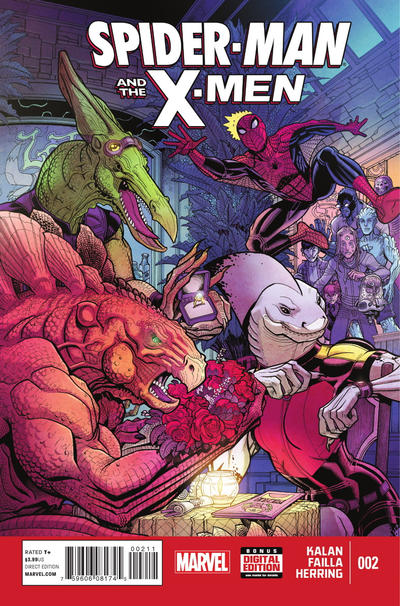

In [29]:
print '../covers/' + covers[700]
im = Image.open('../covers/' + covers[700])
im

## Filter Cover Spreads

In [22]:
# import numpy as np

# for i in range(0, len(covers)):
#     im = Image.open('../covers/' + covers[i])
#     width, height = im.size
#     if (height < 565.0) | (height > 637.0):
#         pass
#     else:
#         im_resize = resize_im(im, (400, 614))
#         im_resize.save('../covers_filtered/' + covers[i])

## MetaData DataFrame

In [43]:
import glob
import pandas as pd

path =r'./metadata' # use your path
all_files = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_, index_col=0, header=0)
    list_.append(df)
df = pd.concat(list_).reset_index(drop=True)

### Pre-process MetaData

#### Publication Rights

In [44]:
def update_rights(t):
    if len(t) == 2:
        return t
    else:
        return ['NaN', t[0]]

rights = df['right'].fillna('NaN').apply(lambda x: re.sub(r"[^a-zA-Z0-9]+", ' ', x).strip())
rights = rights.apply(lambda x: x.split(' ')).apply(lambda x: pd.DataFrame(update_rights(x)))
rights = pd.concat(list(rights.values), axis=1).T.reset_index(drop=True)
rights.columns = ['publication_month', 'publication_year']
rights.head()

,publication_month,publication_year
0,July,2010
1,November,2012
2,August,2012
3,September,2010
4,July,2005


In [45]:
from datetime import datetime

def string_to_date(s):
    try:
        return datetime.strptime(s, "%B, %Y")
    except:
        return np.nan

dates = map(lambda x: string_to_date(x), 
    rights['publication_month'] + ', ' + rights['publication_year'])
min_date = pd.Series(dates).dropna().min()
months_old = map(lambda x: np.round((x - min_date).days / 30.42, 0), pd.Series(dates))
months_old = pd.Series(months_old, name='months_old')
months_old.head()

0    562.0
1    590.0
2    587.0
3    564.0
4    502.0
Name: months_old, dtype: float64

#### Title

In [46]:
def update_title(t):
    if len(t) == 2:
        return t
    else:
        return [t[0], 'NaN']
    
title = df['title'].str.split(' #').apply(lambda x: pd.DataFrame(update_title(x)))
title = pd.concat(list(title.values), axis=1).T.reset_index(drop=True)
title.columns = ['title_name', 'title_issue']
title.head()

,title_name,title_issue
0,X-Men: We Are the X-Men,NaN
1,X-Men,35
2,X-Men,30
3,Dark X-Men,NaN
4,X-Men: Golgotha,NaN


In [118]:
filter(lambda x: '[' in x, title['title_issue'].unique())

['8 [X-Men Team Variant]',
 '12 [X-Men Team Variant]',
 '137 [Newsstand]',
 '131 [Newsstand]',
 '131 [Direct]',
 '9 [X-Men Team Variant]',
 '11 [X-Men Team Variant]',
 '137 [Direct]',
 '4 [Regular Edition]',
 '2 [Regular Edition]',
 '1  [Direct Edition]',
 '6 [Regular Edition]',
 '5 [Regular Edition]',
 '1 [Skottie Young Marvel Babies Variant]',
 '2 (7) [Limited Variant Edition]',
 '527 [Women of Marvel variant]',
 '[nn]',
 '1 [Direct Edition]',
 '5 (48) [Limited Variant Edition]',
 '1 [Newsstand Edition]',
 '1 [Marvel Babies Variant by Skottie Young]',
 '33 [Stacey Lee Women of Marvel Variant]',
 '7 (105) [Limited Variant Edition]',
 '7 [Regular Edition]',
 '1 [Regular Edition]',
 '8 [Regular Edition]',
 '3 [Regular Edition]',
 '514 [Marvel 70th Anniversary Border ]',
 '1 (3) [Limited Variant Edition]',
 '6 (61) [Limited Variant Edition]',
 '223 [Marvel 70th Anniversary Cover]',
 '1 [Variant Cover by Paolo Rivera]',
 '1 [Brahm Revel Cover]',
 '1 [Marvel Baby Variant by Skottie Young]'

#### Metadata

In [47]:
from ast import literal_eval 

pencils = df['metadata'].apply(lambda x: literal_eval(x).get('pencils'))
letters = df['metadata'].apply(lambda x: literal_eval(x).get('letters'))
inks = df['metadata'].apply(lambda x: literal_eval(x).get('inks'))
reprints = df['metadata'].apply(lambda x: literal_eval(x).get('reprints'))
colors = df['metadata'].apply(lambda x: literal_eval(x).get('colors'))
characters = df['metadata'].apply(lambda x: literal_eval(x).get('characters'))
genre = df['metadata'].apply(lambda x: literal_eval(x).get('genre'))

##### Pencils

In [48]:
scrubbed_pencils = pencils.fillna('NaN').\
    str.replace(r' \(signed\)','').\
    str.replace(r' \(alterations\)','').\
    str.replace(r' \(painted\)','').\
    str.replace(r' \(art reconstruction\)','').\
    str.replace(r' \(painting\)','').\
    str.replace(r' \(painted,','').\
    str.replace(r' \(see notes\)','').\
    str.replace(r' \(see note\)','').\
    str.replace(r' \(painting, signed\)','').\
    str.replace(r' \(signed, painted\)','').\
    str.replace(r' \(sgned, painted\)','').\
    str.replace(r' \(background\)','').\
    str.replace(r' \(digital\)','').\
    str.replace(r' \(credited\)','').\
    str.replace(r' \(signed, credited\)','').\
    str.replace(r' \(Painted\)','').\
    str.replace(r' \(Photo\)','').\
    str.replace(r' \(photo\)','').\
    str.replace(r' \(photograph\)','').\
    str.replace(r' \(original\)','').\
    str.replace(r' \(original artist\)','').\
    str.replace(r' \(sketch\)','').\
    str.replace(r' \(cover sketch\)','').\
    str.replace(r' \(layout\)','').\
    str.replace(r' \(Layouts\)','').\
    str.replace(r' \(Backgrounds\)','').\
    str.replace(r' \(frame\)','').\
    str.replace(r" \(painting",'').\
    str.replace(r" \(Painting",'').\
    str.replace(r" signed\)",'').\
    str.replace(r' \((Original X-Men figures)\)','').\
    str.replace(r' \((original X-Men figures)\)','').\
    str.replace(r' \((Stan Lee figure)','').\
    str.replace('\[([^\[\]]+)\]\,?\s?', '')

In [49]:
pencils_df = pd.DataFrame(map(lambda x: x.strip().split('; '), scrubbed_pencils)).\
    reset_index(drop=True).\
    fillna('NaN')
pencils_df.columns = ['pencils_1', 'pencils_2', 'pencils_3', 'pencils_4']

In [50]:
def concat_pencils(row):
    if row['pencils_1'] == 'NaN':
        return np.nan
    elif row['pencils_2'] == 'NaN':
        return row['pencils_1']
    elif row['pencils_3'] == 'NaN':
        return row['pencils_1'] + ', ' + row['pencils_2']
    elif row['pencils_4'] == 'NaN':
        return row['pencils_1'] + ', ' + row['pencils_2'] + ', ' + row['pencils_3']
    else:
        return np.nan

pencils_concat = []
for i in range(0, len(pencils_df)):
    pencils_concat.append(concat_pencils(pencils_df.loc[i,]))
    
pencils_concat = pd.DataFrame(pencils_concat, columns=['pencils'])
pencils_concat.head()

,pencils
0,NaN
1,NaN
2,NaN
3,NaN
4,Salvador Larroca


In [51]:
pencils_onehot = pd.get_dummies(pencils_concat['pencils'])
pencils_onehot.columns = map(lambda x: ('pencils_' + x).lower(), pencils_onehot.columns)
pencils_onehot.head()

,pencils_?,"pencils_?, rick leonardi",pencils_aaron kuder,pencils_aaron lopresti,pencils_aco,pencils_adam hughes,pencils_adam kubert,"pencils_adam kubert, tim hildebrant, greg hildebrant",pencils_adam pollina,pencils_adam warren,...,pencils_walt simonson,pencils_walter simonson,pencils_werner roth,"pencils_werner roth, jack kirby","pencils_werner roth, jack kirby (kulkulkan figure)","pencils_werner roth, marie severin",pencils_whilce portacio,pencils_wilfred santiago,pencils_yancey labat,pencils_yanick paquette
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Characters

In [52]:
def get_team(list_of_characters):
    d = []
    for i in range(0, len(list_of_characters)):
        parens_start = list_of_characters[i].find('[')
        parens_end = list_of_characters[i].find(']')
        if parens_start > 0:
            d.append({'team': list_of_characters[i][:(parens_start)].strip(),
                      'characters': list_of_characters[i][(parens_start + 1): parens_end].strip().split('; ')})
        else:
            d.append({'team': 'NaN',
                      'characters': list_of_characters[i].strip().split('; ')})
    return d

characters_df = pd.DataFrame.from_dict(get_team(characters.fillna('NaN')))

Character Teams

In [53]:
character_teams = pd.get_dummies(characters_df['team'])
character_teams.columns = map(lambda x: ('team_' + x).lower(), character_teams.columns)

Characters

In [54]:
characters_df = pd.concat(map(lambda x: pd.Series(x), characters_df['characters'].values), axis=1)
characters_melt = pd.melt(characters_df).dropna(how='any', axis=0)
characters_melt.columns = ['index', 'character']
characters_melt.head()

characters_onehot = pd.concat([
                        characters_melt.loc[characters_melt['character'] != 'NaN', 'index'],
                        pd.get_dummies(characters_melt.loc[characters_melt['character'] != 'NaN', 'character'])],
                    axis=1).groupby('index').sum()
characters_onehot.columns = map(lambda x: ('character_' + x).lower(), characters_onehot.columns)

In [56]:
df = df.\
        join(title).\
        join(characters_onehot).\
        join(character_teams).\
        join(pencils_onehot).\
        join(rights).\
        join(months_old).drop(['right', 'title'], axis=1)

### Filter for covers

In [97]:
training_set = df.replace('NaN', np.nan).loc[(
                (df['cover'].notnull()) &
                (df['title_issue'] != 'NaN') &
                (df['publication_year'] != 'NaN') & 
                ((df['publication_year'].str.contains('19')) | 
                 (df['publication_year'].str.contains('20')))), ['cover', 'title_name', 'title_issue', 'publication_year']].\
                drop_duplicates().\
                sort_values(['publication_year','title_name','title_issue']).\
                reset_index(drop=True)

In [111]:
training_set.groupby('title_name').count().sort_values('title_issue', ascending=False)

,cover,title_issue,publication_year
title_name,,,
The Uncanny X-Men,676,676,676
X-Men,414,414,414
The X-Men,211,211,211
All-New X-Men,138,138,138
New X-Men,119,119,119
Ultimate X-Men,119,119,119
Astonishing X-Men,117,117,117
Uncanny X-Men,117,117,117
Avengers vs. X-Men,112,112,112


In [137]:

training_set.loc[((training_set['title_name'] == 'The Uncanny X-Men') &
                  (~training_set['title_issue'].str.endswith(']'))), ]

,cover,title_name,title_issue,publication_year
221,./covers/The Uncanny X-Men #142.jpg,The Uncanny X-Men,142,1981
229,./covers/The Uncanny X-Men #147.jpg,The Uncanny X-Men,147,1981
253,./covers/The Uncanny X-Men #153.jpg,The Uncanny X-Men,153,1982
254,./covers/The Uncanny X-Men #154.jpg,The Uncanny X-Men,154,1982
256,./covers/The Uncanny X-Men #155.jpg,The Uncanny X-Men,155,1982
257,./covers/The Uncanny X-Men #156.jpg,The Uncanny X-Men,156,1982
259,./covers/The Uncanny X-Men #157.jpg,The Uncanny X-Men,157,1982
261,./covers/The Uncanny X-Men #158.jpg,The Uncanny X-Men,158,1982
263,./covers/The Uncanny X-Men #159.jpg,The Uncanny X-Men,159,1982
265,./covers/The Uncanny X-Men #160.jpg,The Uncanny X-Men,160,1982
